# Machine Learning hand-in 4
This handin is about implementing and using representative-based clustering algorithms. If you have made your way through the programming exercises for weeks 11 and 12 you are almost done with the first two parts of the handin. 

The handin is mandatory, and should be done in groups of 2-3 students. Each group
must prepare a report in PDF format as outlined below. Please submit all your
Python files in a zip file, and your PDF report outside the zip file, to
Blackboard no later than **Friday, December 8 at 9:00 AM**.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Implementing the Algorithms
In this section you must implement Lloyds algorithm andthe Gaussian Mixture Expectation
Maximization algorithm. Please refer to p. 349 and p. 335 of the textbook [ZM] or see the exercises from week 11/12. If you already did this during class copy paste them in below. 

<!-- 
For the EM algorithm, you may use the `pdf` function below to compute the probability
densities in the Gaussian Mixture model.

You should use the Python code displayed previously to load and display Iris data
and apply PCA to reduce it from four dimensions to two.

Use the 2d Iris data to validate your algorithms (compare the results you get
with the results in the textbook on the same data), and run your algorithms on
the 4d data and compare.

You should read the deliverables section at the very end of the notebook before getting into detail with the code below.-->

### 1.1 Lloyd's Algorithm
You are allowed to structure your code however you want. The template below is identical to the one given in class at week 11. We recommend you use it. 

In [14]:
def lloyds_algorithm(X, k, T):
    """ Clusters the data of X into k clusters using T iterations of Lloyd's algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations to run Lloyd's algorithm. 
        
        Returns
        -------
        clustering: A vector of shape (n, ) where the i'th entry holds the cluster of X[i].
        centroids:  The centroids/average points of each cluster. 
        cost:       The cost of the clustering 
    """
    n, d = X.shape
    
    # Initialize clusters random. 
    clustering = np.random.randint(0, k, (n, )) 
    centroids  = np.zeros((k, d))
    
    # Used to stop if cost isn't improving (decreasing)
    cost = 0
    oldcost = 0
    
    # Column names
    print("Iterations\tCost")
    
    for i in range(T):
        
        # Update centroid
        # YOUR CODE HERE
        # END CODE
        
        
        # Update clustering 
        # YOUR CODE HERE
        # END CODE
        
        # Compute and print cost
        cost = 0
        for j in range(n):
            cost += np.linalg.norm(X[j] - centroids[clustering[j]])**2    
        print(i+1, "\t\t", np.sqrt(cost))
        
        
        # Stop if cost didn't improve more than epislon (decrease)
        if np.isclose(cost, oldcost): break 
        oldcost = cost
        
    return clustering, centroids, cost

clustering, centroids, cost = lloyds_algorithm(X, 3, 100)

### 1.2 Expectation Maximization Algorithm
Again, you are allowed to structure your code however you want. The template below is identical to the one given in class at week 12. We recommend you use it. 

## Combine Lloyd's algorithm with the Expectation Maximization algorithm 
In order to determine an initial set of cluster centers for the EM algorithm, one can utilize the best centroids determined by Lloyd's algorithm. For this, run Lloyd's algorithm several times, and choose the best one. Then run the EM algorithm with the initial means as the centroids obtained in the previous step.

Test the final algorithm on the 2d IRIS data and to compare the results with Lloyd's Algorithm and the Expectation Maximization algorithm (without Lloyd's initialization). 

In [17]:
import sklearn.datasets
iris = sklearn.datasets.load_iris()
X = iris['data'][:,0:2] # reduce dimensions so we can plot what happens.
k = 3

# YOUR CODE HERE
# END CODE

<b>Report section 1: </b>
- asd

## 2. Evaluating clusterings

Implement the F1 score (build the contingency table p. 426, measure pp. 427-428)
and the silhouette coefficient (pp. 444-445), and compare the quality of
several runs of your algorithms with different values for *k*.

### Silhouette Coefficient

Begin by implementing the Silhouette coefficient, as explained in the lecture and discussed during the practical exercises of the last two weeks. You can use the following template

In [ ]:
def silhouette(data, clustering): 
    n, d = data.shape
    k = np.unique(clustering)[-1]+1

    # YOUR CODE HERE
    silh = None
    # END CODE

    return silh

# Try to find the best 'k' for both KMeans and EM. 

### F1 Score

Now implement a function that compute the F1 score. You can use the following template

In [18]:
def f1(predicted, labels):
    '''
    TODO: Add Docstring of f1 coefficient, so that students know how the input should look like and what they should return
    '''
    n, = predicted.shape
    assert labels.shape == (n,)
    r = np.max(predicted) + 1
    k = np.max(labels) + 1

    # Implement the F1 score here
    # YOUR CODE HERE
    contingency = None
    F_individual = None
    F_overall = None
    # END CODE

    assert contingency.shape == (r, k)
    return F_individual, F_overall, contingency

<b>Report section 2: </b>Are there any differences between the two quality measures?

HINT: External/internal measures supervised/unsupervised.

<b>

# 3. Compressing images
In class week 11 you saw how to do image compression using clustering. In this section you will revisit image compression. Find a picture you like. You could Google your favourite animal, car, disney cartoon character or take a photo of your study group. You should now use Lloyd's algorithm, EM or a combination to compress your image. 

The size of images can be measured in bytes. The following code downloads an image, displays it and prints the size of the images in bytes:

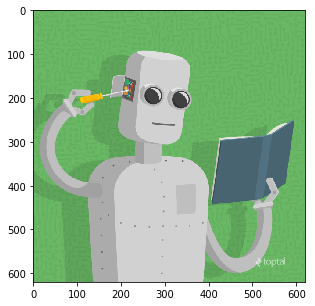

The image consumes a total of 106292 bytes. 
The goal is to compress the images 10 times so it consumes no more than 10629 bytes. 


In [9]:
import scipy.misc
import matplotlib.pyplot as plt
import os

def download_image(url):
    filename = url[url.rindex('/')+1:]
    try:
        with open(filename, 'rb') as fp:
            return scipy.misc.imread(fp) / 255
    except FileNotFoundError:
        import urllib.request
        with open(filename, 'w+b') as fp, urllib.request.urlopen(url) as r:
            fp.write(r.read())
            return scipy.misc.imread(fp) / 255
 
img_facade = download_image('https://uploads.toptal.io/blog/image/443/toptal-blog-image-1407508081138.png')

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(img_facade)
plt.show()

size = os.stat('toptal-blog-image-1407508081138.png').st_size

print("The image consumes a total of %i bytes. "%size)
print("The goal is to compress the images 10 times so it consumes no more than %i bytes. " %(size/10))

Again, you can use the code from class week 11 as inspiration, but you do not have to. The following code is identical to that you saw in class. 

In [10]:
def compress_kmeans(im, k, T):
    height, width, depth = im.shape
    data = im.reshape((height * width, depth))
    clustering, centroids, score = lloyds_algorithm(data, k, 5)
    
    # make each entry of data to the value of it's cluster
    data_compressed = data
    
    for i in range(k): data_compressed[clustering == i] = centroids[i] 
    
    im_compressed = data_compressed.reshape((height, width, depth))
    plt.figure()
    plt.imshow(im_compressed)
    plt.show()

def compress_facade(k=4, T=100):
    img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
    compress_kmeans(img_facade, k=k, T=T)

def compress_stairs(k=4, T=100):
    img_stairs = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_stairs.jpg')
    compress_kmeans(img_stairs, k=k, T=T)

When you display the compressed image you can save it by hovering your mouse over it. After saving it you can determine the size of the image by using the `os.stat('NAME OF IMAGE').st_size` command. 

<b>Report: </b>Include the original and the compressed image. You should state the sizes of both images in bytes, and briefly (5 lines) explain how you compressed the image. 

# 4. Sampling from MNIST
The code below runs `sklearn`'s implementation of EM on the MNIST dataset. Because the clusters are represented as gaussians we can sample from ..


In [11]:
code


NameError: name 'code' is not defined

Try to change the parameters above and get as good looking images as possible. Would higher or lower $T$ and $k$ be a good idea? 

You should not expect to get images that looks as nice as the real images. Expect similar results as what you saw in class week 12, maybe with minor improvements. 

<b>Report section 4: </b>
- Explain why we can generate images of digits using the Expectation Maximization algorithm. 
- Why do the images look <a hrf="https://boofcv.org/images/1/18/Example_lena_denoise_noisy.jpg" target="new">noisy</a>?

## Deliverables
As part of the handin you must submit the following.

### Code
You must include a `.py` file including your implementations of the two algorithms (Lloyd and EM) and the two evaluation measures (Silhouette coefficient and F1 score). Alternatively, you could code everything in here and upload the final IPython Notebook. 

### Report
Your report should be no more than 3 pages and clearly state who is in the group. It must cover:

* The status of the work, i.e., does it work, if not, then why.
* A discussion of plots of at least two runs of your algorithm
  implementations detailing what you can see. Make sure that you relate this
  to the discussion in the lecture or textbook about the strengths and
  weaknesses of the algorithms.
* A discussion of plots of the evaluation measures F1 and silhouette
  coefficient, detailing what you can learn from them. Include an explanation
  of what the evaluation measures reflect. TODO: Compute for several k's?
* Describe how you can use one of the clustering algorithms for image
  compression, and demonstrate the results for at least one algorithm on both
  images, discussing their quality and giving a reasoning for the differences.
  
